# Introduccion a Simpy

### Ejemplo del negocio de lavado de autos

Este ejemplo permite simular un negocio de lavado de automóviles. De igual forma, es importante destacar que este ejemplo aborda los siguientes puntos:
- Estados de espera por otros procesos
- Recursos: clase Resource

### Características del sistema real a simular

Es importante observar que el negocio de lavado de autos tiene características propias a su naturaleza. A continuación establecemos dichas peculiaridades a tener en mente en el momento de llevar a cabo la simulación:
- El negocio tiene un número limitado de máquinas de lavado.
- Se puede recibir un cierto número de vehículos para ser lavados, de los cuáles los que no estén siendo procesados tendrán que esperar.
- Una vez que un vehículo entra a la máquina, debe ser lavado y solo al finalizar la limpieza podrá salir de la misma, dejando un espacio libre a otro vehículo.

### Desarrollo de la simulación

Como primer paso, importamos las librerías necesarias y establecemos los parámetros requeridos:
- Variables de interésTiempo de simulación
- Parámetros de inicialización (número de máquinas, tiempo de lavado, intervalo de llegada de vehículos).
- Considerar 3 tipos de vehículos con 3 diferentes tiempos de lavado:
    - Bus: 20 minutos
    - Automóvil: 7 minutos
    - Furgoneta: 12 minutos
- Considere que a partir de la entrada del vehículo para ser lavado, deberán tomarse en cuenta los siguientes tiempos correspondientes al proceso de traslado desde la recepción a la máquina de lavado:
    - Bus: 4 minutos
    - Automóvil: 1 minuto
    - Furgoneta: 2 minutos
- Realice una gráfica comparativa de la simulación con 3 y con 4 máquinas de lavado

In [1]:
import simpy
import random
import numpy as np

In [2]:
# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57 
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 3
# Tiempo que tarda en lavarse un vehiculo (minutos)
TIEMPO_LAVADO = {1:20, 2:7, 3:12}
# Intervalo de tiempo en que llegan vehiculos (minutos)
INTERVALO_LLEGADA = 9
# Tiempo de simulación
TIEMPO_SIMULACION = 60
# Vehiculos
VEHICULOS = {1:'Bus', 2:'Automóvil', 3:'Furgoneta'}
# Tiempo de traslado hasta la máquina (minutos)
TIEMPO_TRASLADO = {1:4, 2:1, 3:2}
# Diccionario con las máquinas de lavado estado inicial libre
MAQUINASLIBRES = {}
keys = range(NUM_MAQUINAS)
values = ["Libre"]

In [3]:
for i in keys:
        MAQUINASLIBRES[i] = values[0]
        
cantidadVehiculos={}
keys = range(NUM_MAQUINAS)
values = [0]
for i in keys:
        cantidadVehiculos[i] = values[0]

class Lavanderia(object):
    
    def __init__(self, environment, num_maquinas, tiempo_lavado):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_lavado = tiempo_lavado
        
    def lavar_vehiculo(self, vehiculoIndex):
        # Este metodo representa el proceso de lavado del vehículo.
        # Se ingresa el vehículo y se lava
        
        # Simulamos el tiempo que tarda en lavarse el vehiculo
        # Es importante notar que la instruccion "yield" es distinta de "sleep"
        # ya que esta ultima bloquea el hilo de ejecucion durante 't' unidades de tiempo,
        # mientras que 'yield' no bloquea el hilo de ejecucion, solo lo suspende mientras
        # el evento de 'lavado' se realice                
        yield self.env.timeout(TIEMPO_LAVADO.get(vehiculoIndex))
        
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        #print('Removido  {%d%%} suciedad vehiculo => %s ' \  % (random.randint(30,90), vehiculo))
        
    def maquinaLibre(self, key):
        if MAQUINASLIBRES.get(key) == 'Libre':
            return True
        else:
            return False
        
    def llegarMaquina(self, vehiculoId):
        # Este método  representa el tiempo desde la llegada del vehículo hasta ser transportardo 
        # hacia una máquina de lavado            
        yield self.env.timeout(TIEMPO_TRASLADO.get(vehiculoId))
    
    def abandonarLavanderia(self):
        # Este método representa el tiempo desde que el vehículo termina de ser lavado y abandona
        # la lavanderia.
        yield self.env.timeout(1)
       
    
def llegada_vehiculo(env, vehiculoId, lavanderia,idMaquina):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehículo: %s a la hora %.2f.' % (VEHICULOS.get(vehiculoId), env.now))
         
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado      
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina

        # Indicamos que vehiculo fue transportado desde la entrada hacia una máquina
        # de lavado.
        yield env.process(lavanderia.llegarMaquina(vehiculoId))
        print('Vehiculo [%s] ASIGNADO a la máquina: %s.' % (VEHICULOS.get(vehiculoId), idMaquina+1))
        
        # El vehiculo entra a ser lavado en una máquina designada
        print('Entra [%s] a lavarse a la hora %.2f.' % (VEHICULOS.get(vehiculoId), env.now))

        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(vehiculoId))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] SALE lavado a las %.2f de la máquina: %s.' % (VEHICULOS.get(vehiculoId), env.now, idMaquina+1))

        # Finalizado el proceso de lavado del vehículo, transcurre un tiempo hasta que abandona
        # la máquina y sale de la lavanderia.
        yield env.process(lavanderia.abandonarLavanderia())    
        MAQUINASLIBRES[idMaquina]='Libre'
        print('Vehiculo [%s] abandona la lavanderia a las: %.2f.' % (VEHICULOS.get(vehiculoId), env.now))
            
def ejecutar_simulacion(env, num_maquinas, tiempo_lavado, intervalo):
    lavanderia=Lavanderia(env, num_maquinas, tiempo_lavado)
    # Creamos 3 llegadas de vehiculos iniciales
    for i in range(3):
        for j in range(num_maquinas):
            if lavanderia.maquinaLibre(j):
                MAQUINASLIBRES[j]='Ocupada'
                env.process(llegada_vehiculo(env, random.randint(1,3), lavanderia,j))
                cantidadVehiculos[j]+=1
                break;
            else:
                j-=1
                i-=1
                
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-2, intervalo+2))
        #Mientras se lavan los vehiculos generamos mas vehiculos
        for j in range(num_maquinas):
            if lavanderia.maquinaLibre(j):
                MAQUINASLIBRES[j]='Ocupada'
                env.process(llegada_vehiculo(env, random.randint(1,3), lavanderia,j))
                cantidadVehiculos[j]+=1
                break;
            else:
                j=0
        
        
print('Lavanderia UPS- By: Paulo Gonzalez')
# Inicializamos la semilla aleatoria
#random.seed(33)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO, INTERVALO_LLEGADA))
# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until= TIEMPO_SIMULACION) 
print(cantidadVehiculos)

Lavanderia UPS- By: Paulo Gonzalez
Llega vehículo: Automóvil a la hora 0.00.
Llega vehículo: Bus a la hora 0.00.
Llega vehículo: Bus a la hora 0.00.
Vehiculo [Automóvil] ASIGNADO a la máquina: 1.
Entra [Automóvil] a lavarse a la hora 1.00.
Vehiculo [Bus] ASIGNADO a la máquina: 2.
Entra [Bus] a lavarse a la hora 4.00.
Vehiculo [Bus] ASIGNADO a la máquina: 3.
Entra [Bus] a lavarse a la hora 4.00.
Vehiculo [Automóvil] SALE lavado a las 8.00 de la máquina: 1.
Vehiculo [Automóvil] abandona la lavanderia a las: 9.00.
Llega vehículo: Furgoneta a la hora 18.00.
Vehiculo [Furgoneta] ASIGNADO a la máquina: 1.
Entra [Furgoneta] a lavarse a la hora 20.00.
Vehiculo [Bus] SALE lavado a las 24.00 de la máquina: 2.
Vehiculo [Bus] SALE lavado a las 24.00 de la máquina: 3.
Vehiculo [Bus] abandona la lavanderia a las: 25.00.
Vehiculo [Bus] abandona la lavanderia a las: 25.00.
Llega vehículo: Automóvil a la hora 26.00.
Vehiculo [Automóvil] ASIGNADO a la máquina: 2.
Entra [Automóvil] a lavarse a la hora 27

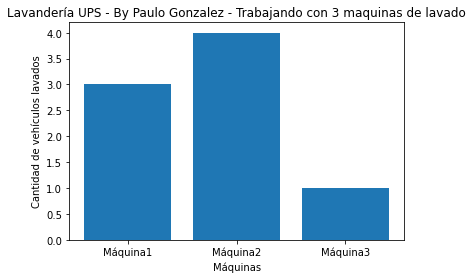

In [7]:
import matplotlib.pyplot as plt
maquinas = ['Máquina1', 'Máquina2', 'Máquina3']
values = cantidadVehiculos.values()

plt.bar(maquinas, values)
plt.xlabel('Máquinas') 
plt.ylabel('Cantidad de vehículos lavados') 
  
# displaying the title
plt.title("Lavandería UPS - By Paulo Gonzalez - Trabajando con 3 maquinas de lavado")
plt.show()